# NeurIPS 2021 Submission 4400
# A Normative and Biologically Plausible Algorithm for Independent Component Analysis
## Fig.2 Panel A. 
### Notebook for visualizing the ICA task on Synthetic data

In [24]:
import numpy as np
from scipy.io import wavfile
# from FastICA import FastICA
from FOBI import FOBI
import utilities as utl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import norm, kurtosis
from scipy import signal
import scipy
import time
import pylab as pl


def get_data(seed=101, mix_dim=5, task_type='linear', samples=10000):
    # 10kHz, 4000 samples by default
    # This version of the task adds laplacian noise as a source and uses a
    # non-linear partially non-invertible, possibly overdetermined,
    # transformation.
    np.random.seed(seed)
    t = np.linspace(0, samples * 1e-4, samples)
    two_pi = 2 * np.pi
    s0 = np.sign(np.cos(two_pi * 155 * t))
    s1 = np.sin(two_pi * 180 * t)
    s2= signal.sawtooth(2 * np.pi*200  * t)
    s3 = np.random.laplace(0, 1, (samples,))
    x = np.stack([s0, s1, s2,s3])
    mix_mat = np.random.uniform(-.5, .5, (mix_dim, mix_dim))
    y = np.dot(mix_mat, x)
    return x, y, mix_mat



In [ ]:
# Generate the sources and mixtures
input_dim=4
all_x, all_y, A = get_data(seed=101,task_type='linear',mix_dim=input_dim)

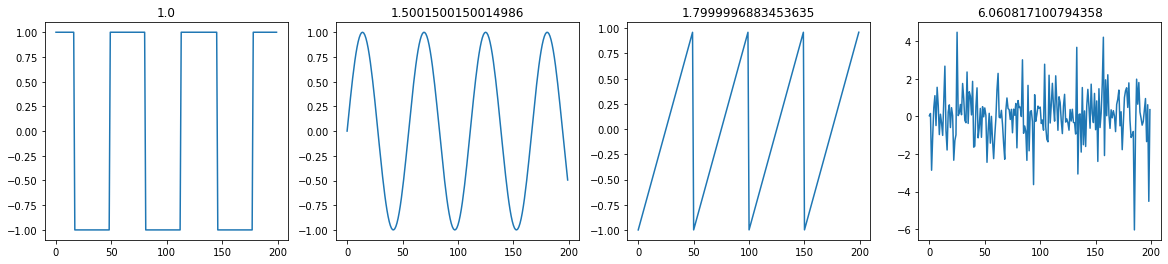

<Figure size 1440x288 with 0 Axes>

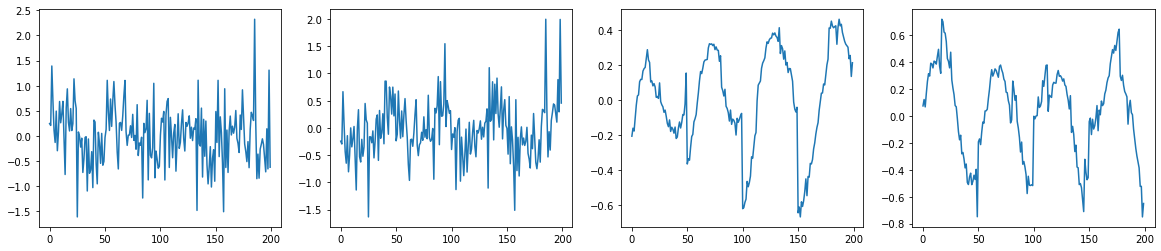

In [25]:
# Plot the sources
figure = plt.figure(figsize=(20,4))

for iter_loop in range(all_x.shape[0]):
    plt.subplot(1,input_dim,iter_loop+1)
    plt.plot(all_x[iter_loop,:200])
    plt.title(str(kurtosis(all_x[iter_loop],fisher=False)))
plt.show()


In [ ]:
# Plot the mixtures
figure = plt.figure(figsize=(20,4))
plt.show()

figure = plt.figure(figsize=(20,4))
for iter_loop in range(all_x.shape[0]):
    plt.subplot(1,input_dim,iter_loop+1)
    plt.plot(all_y[iter_loop,:200])
plt.show()

In [26]:

signals = all_y
#matrix = np.vstack(signals)
matrix = signals

In [27]:
# Run offline Single-layer SM-ICA

#X_SM=(patches_flatten - M.T).T #mixed sources
X_SM=(matrix) #mixed sources
#X_SM=whiteMatrix

dim_Zmixed=X_SM.shape[0]
num_samples_test= X_SM.shape[1]

#print(dim_Zmixed)
#print(num_samples_test)

# Parameters initialization
size_input1=dim_Zmixed
size_output=4

eta=0.01;
tau=0.75;
print(X_SM.shape)

(4, 10000)


In [28]:
whiteMatrix = utl.whitenMatrix(matrix)

X = whiteMatrix

# # Find the individual components one by one
# vectors = []
# for i in range(0, X.shape[0]):
# 	# The FastICA function is used as is from FastICA_image.py, and the it works out of the box
# 	vector = FastICA(X, vectors, eps)
# 	vectors.append(vector)

# # Stack the vectors to form the unmixing matrix
# W = np.vstack(vectors)

# # Get the original matrix
# S = np.dot(W, whiteMatrix)

# Unmixing matrix through FOBI
fobiW = FOBI(X)

# Get the original matrix using fobiW
fobiS = np.dot(fobiW.T, whiteMatrix)


In [29]:

# initialize W
W_off_SL=np.random.randn(size_output,size_input1)

# initialize M PSD
Gen_psd_M = np.random.randn(1000,size_output)
C = np.cov(Gen_psd_M.T)
M_off_SL =np.eye(size_output,size_output)#C

In [30]:
from util import permutation_error

trials = 10 # set the number of trials

SM_ICA_error = np.zeros((trials,num_samples_test))
#SM_ICA_error[i_trial,:] = permutation_error(S[:,idx],bionica_indirect_Y)


In [31]:
Cxx= (1/num_samples_test )*matrix @matrix.T
sig_x, Ux = np.linalg.eig(Cxx)
C_xx_invhalf = Ux@np.diag(1./np.sqrt(sig_x))@Ux.T

nonlin_Z = np.sqrt(sum(whiteMatrix*whiteMatrix))*whiteMatrix
C_nonlin_Z= (1/num_samples_test )*nonlin_Z @nonlin_Z.T

Input_Gram=((C_xx_invhalf@matrix).T@np.linalg.inv(C_nonlin_Z)@C_xx_invhalf@matrix)
Input_Gram_normalized = (Input_Gram.max() - Input_Gram) / ((Input_Gram).max() - (Input_Gram).min())
#Output_Gram=(Y_SL.T@Y_SL)
#Output_Gram_normalized = (Output_Gram.max() - Output_Gram) / ((Output_Gram).max() - (Output_Gram).min())

1 0.0027930736541748047


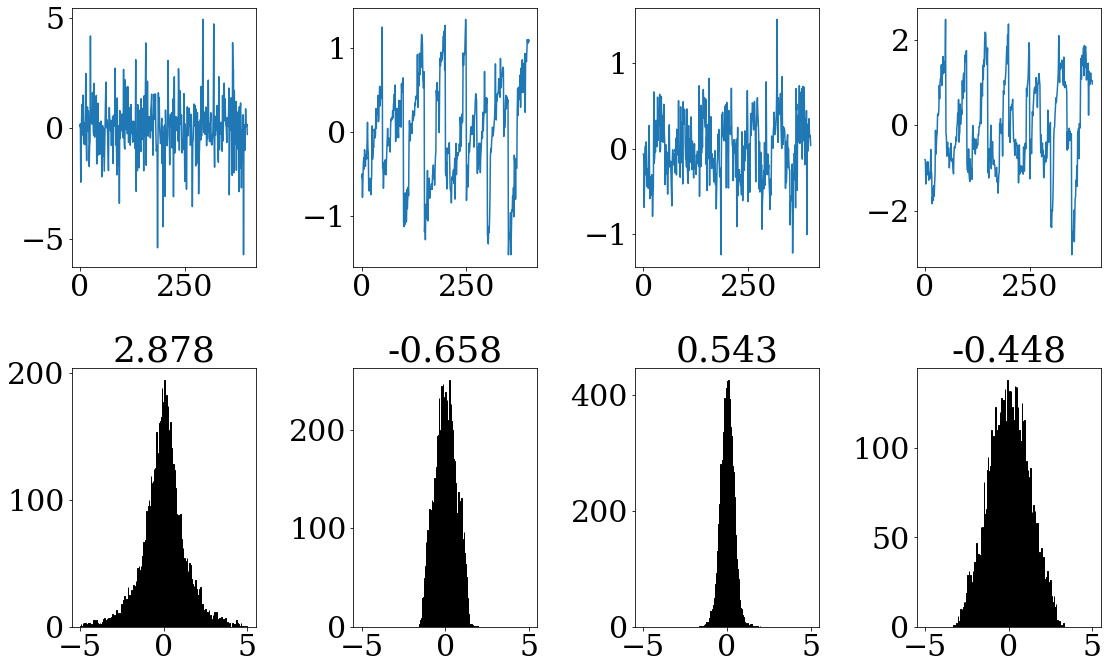

114287 37.553794860839844


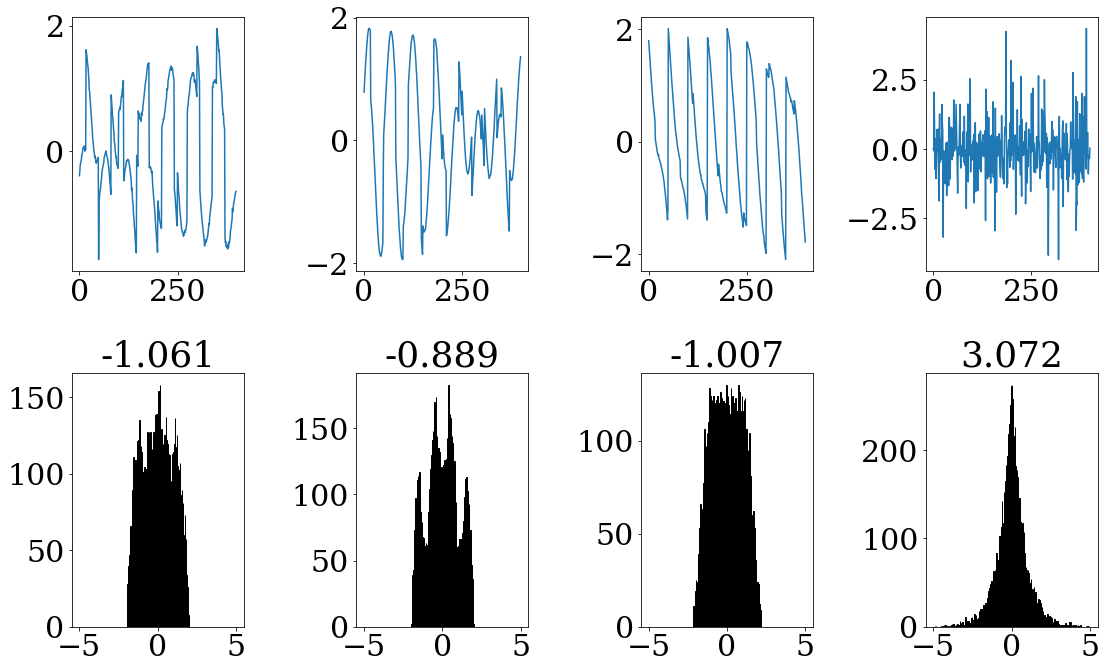

228573 75.74408197402954


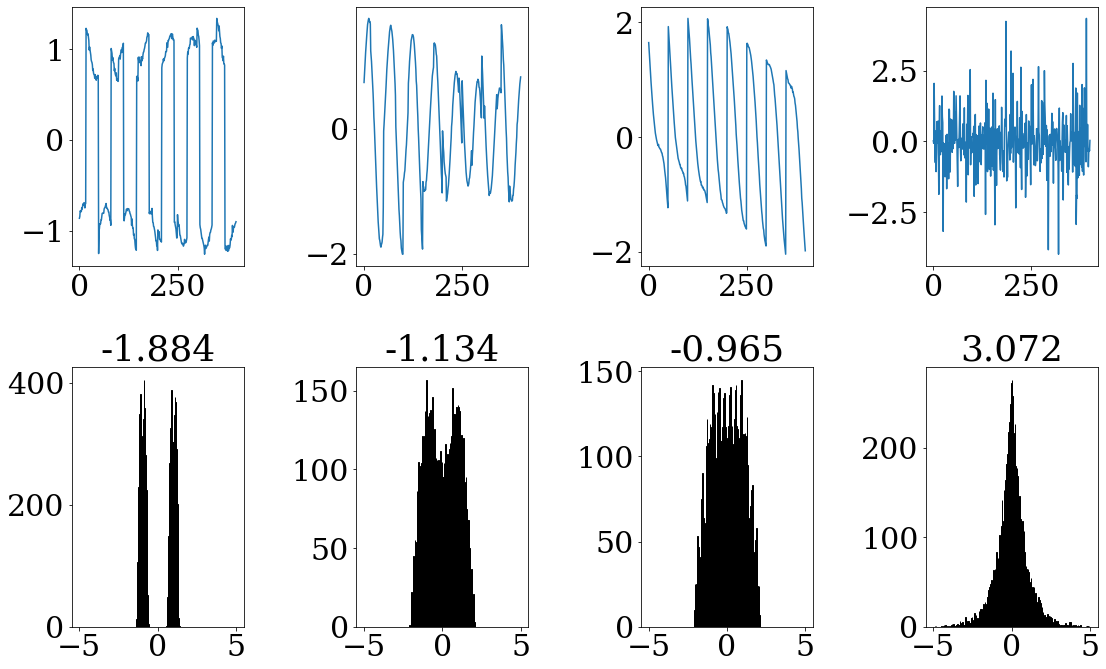

342858 112.74725317955017


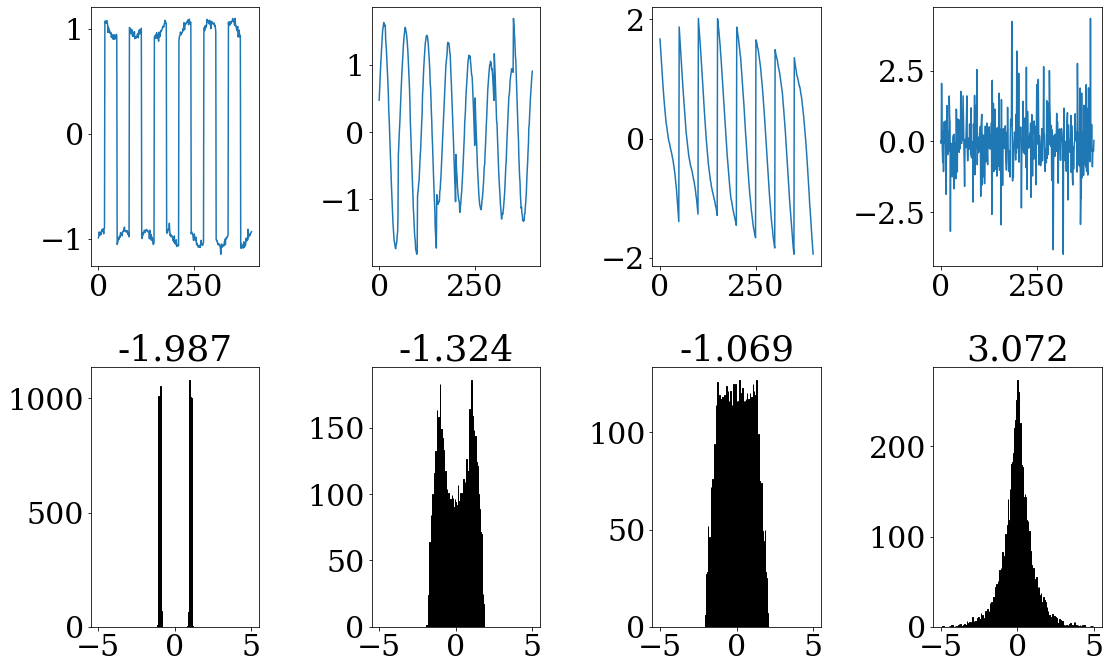

457144 151.14493083953857


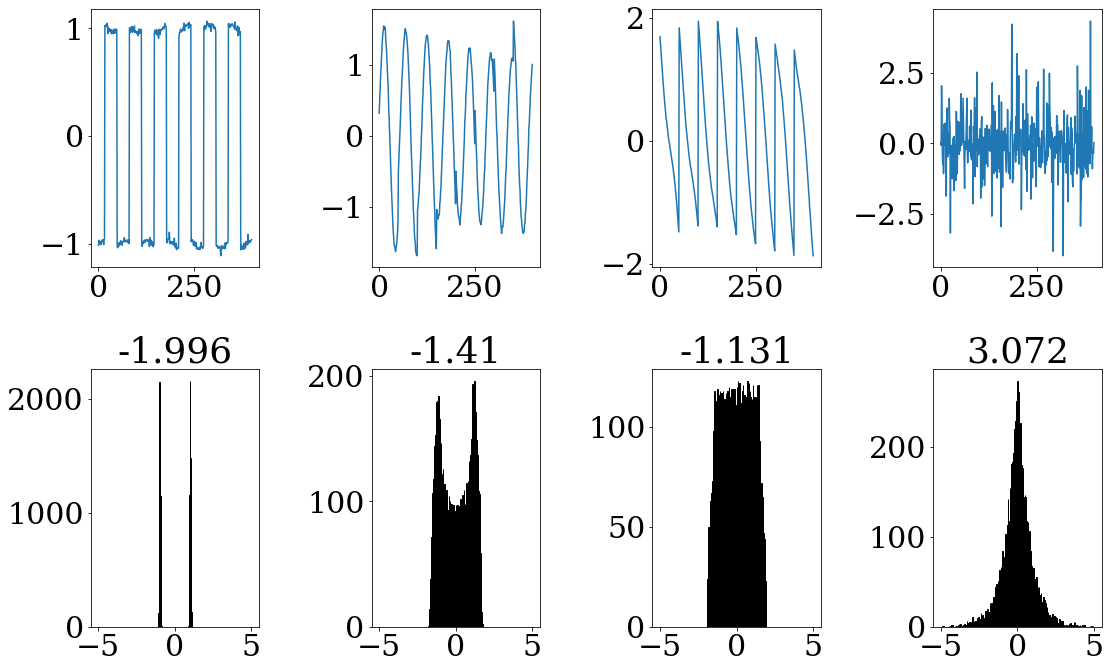

571429 188.5587260723114


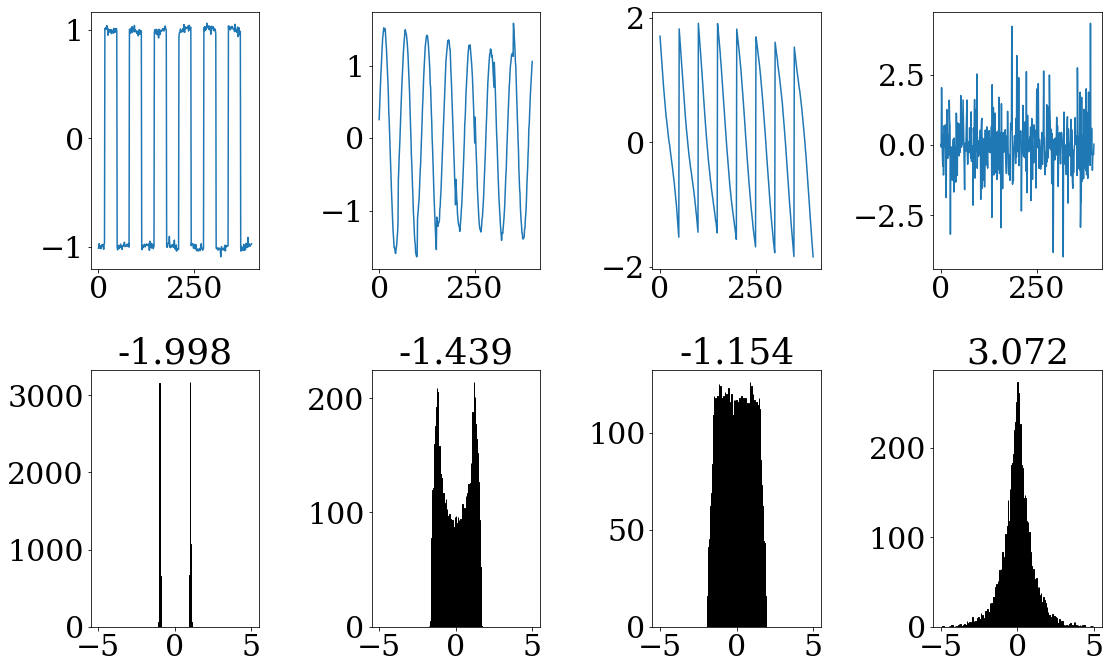

685715 225.01066517829895


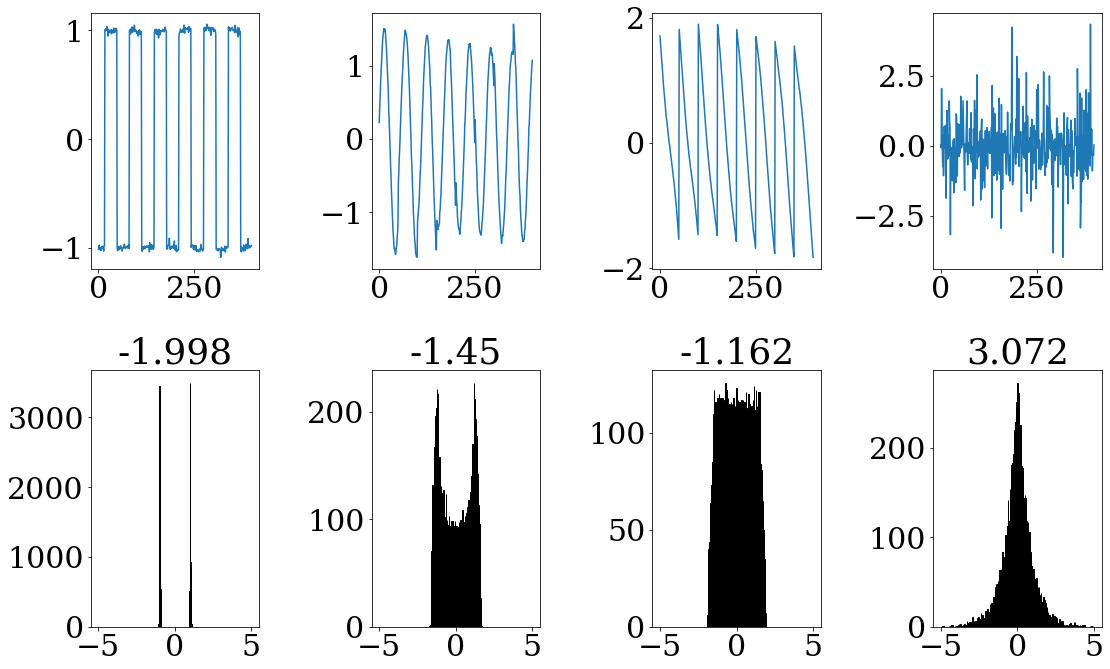

800000 262.72626399993896


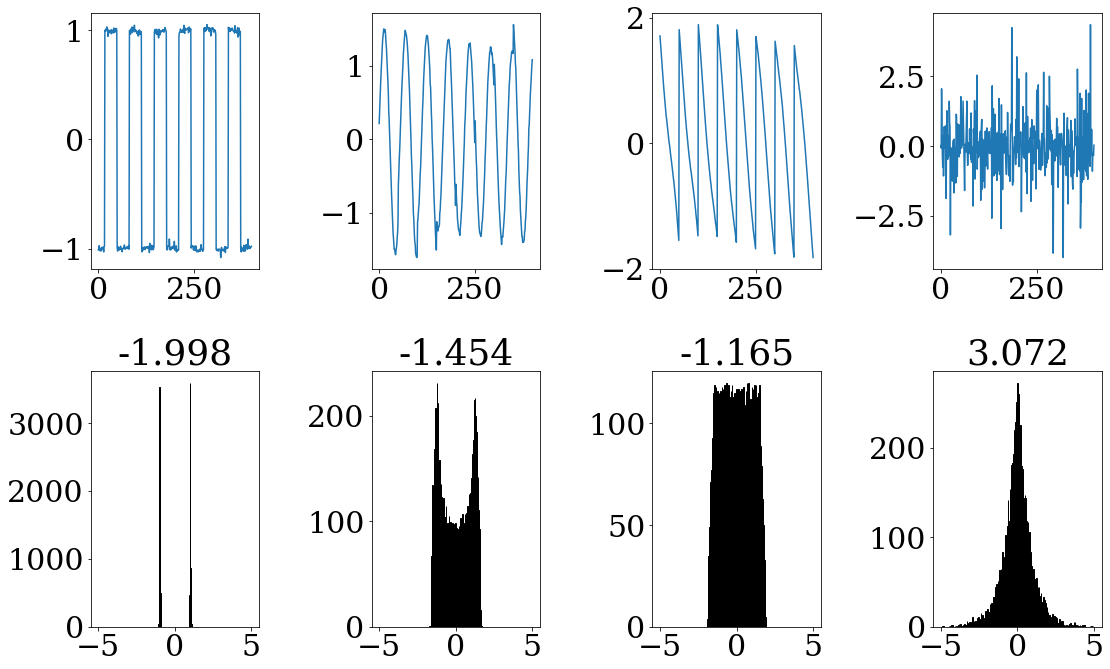

In [46]:
#all_indices_err=np.ceil(np.geomspace(1.0, 100000.0, num=50,endpoint=True))
all_indices_err=np.ceil(np.linspace(1.0, 800000.0, num=8,endpoint=True))

W_off_SL=np.random.randn(size_output,size_input1)

# Offline similarity update nonlin_alpha*C_SL@X_SM.T
# initialize M PSD
Gen_psd_M = np.random.randn(1000,size_output)
C = np.cov(Gen_psd_M.T)
M_off_SL =np.eye(size_output,size_output)

# Offline Training Single Layer
tic = time.time() 

Lambda_PCA=(kurtosis(fobiS.T,fisher=False))
eta=5*10**-3
tau=0.75

X_SM_temp=X_SM
for iter in range(1000000):
  
  ##Single-layer neural network output sources reconstruction
    C_SL=W_off_SL @ X_SM_temp
    Y_SL= np.linalg.inv(M_off_SL) @ C_SL

  # used for the weight update of the second layer
    nonlin_alpha=(sum(Y_SL*Y_SL)**1)
    
  # Single Layer
    W_off_SL= W_off_SL + 2*eta*( (1/num_samples_test)*Y_SL@X_SM_temp.T - (1/num_samples_test)*nonlin_alpha*(np.diag(Lambda_PCA)@C_SL)@X_SM_temp.T)    
    M_off_SL= M_off_SL + (eta/tau)*( (1/num_samples_test)*Y_SL@Y_SL.T  - np.eye(Lambda_PCA.shape[0]))


  # Single Layer
    if iter in all_indices_err:
        toc = time.time() - tic
        print(iter, toc)
        
        figure = plt.figure(figsize=(20,10))

        for iter_loop in range(size_output):
            plt.subplot(2,5,iter_loop+1)
            plt.plot((Y_SL)[iter_loop,:400])
            plt.subplot(2,5,iter_loop+1+5)
            plt.hist(Y_SL[iter_loop], bins=256, range=(-5.0, 5.0), fc='k', ec='k')
            plt.title(str(round(kurtosis(Y_SL[iter_loop],fisher=True),3)))
        plt.tight_layout()
        plt.show()

In [47]:
# rescaling for visualization purposes

Rescaled_Y=(((np.diag(1/(Y_SL.max(axis=1)-Y_SL.min(axis=1)) ))@( Y_SL )).T)
Rescaled_fobi=(((np.diag(1/(fobiS.max(axis=1)-fobiS.min(axis=1) )))@( fobiS )).T)
Rescaled_matrix = (((np.diag(1/(matrix.max(axis=1)-matrix.min(axis=1) )))@( matrix )).T)
Rescaled_sources = (((np.diag(1/(all_x.max(axis=1)-all_x.min(axis=1) )))@( all_x )).T)

kurt_fobiS=np.zeros(fobiS.shape[0])
kurt_SM_ICA=np.zeros(fobiS.shape[0])
kurt_mixtures=np.zeros(fobiS.shape[0])
kurt_sources=np.zeros(fobiS.shape[0])

for iter_rg in range(fobiS.shape[0]):
    kurt_SM_ICA[iter_rg]= kurtosis(Rescaled_Y[:,iter_rg],fisher=True)
    kurt_fobiS[iter_rg]= kurtosis(Rescaled_fobi[:,iter_rg],fisher=True)
    kurt_mixtures[iter_rg]= kurtosis(Rescaled_matrix[:,iter_rg],fisher=True)
    kurt_sources[iter_rg]= kurtosis(Rescaled_sources[:,iter_rg],fisher=True)
    
arg_sort_SM_ICA = np.argsort(kurt_SM_ICA)
arg_sort_fobiS = np.argsort(kurt_fobiS)
arg_sort_mixture = np.argsort(kurt_mixtures)
arg_sort_sources = np.argsort(kurt_sources)


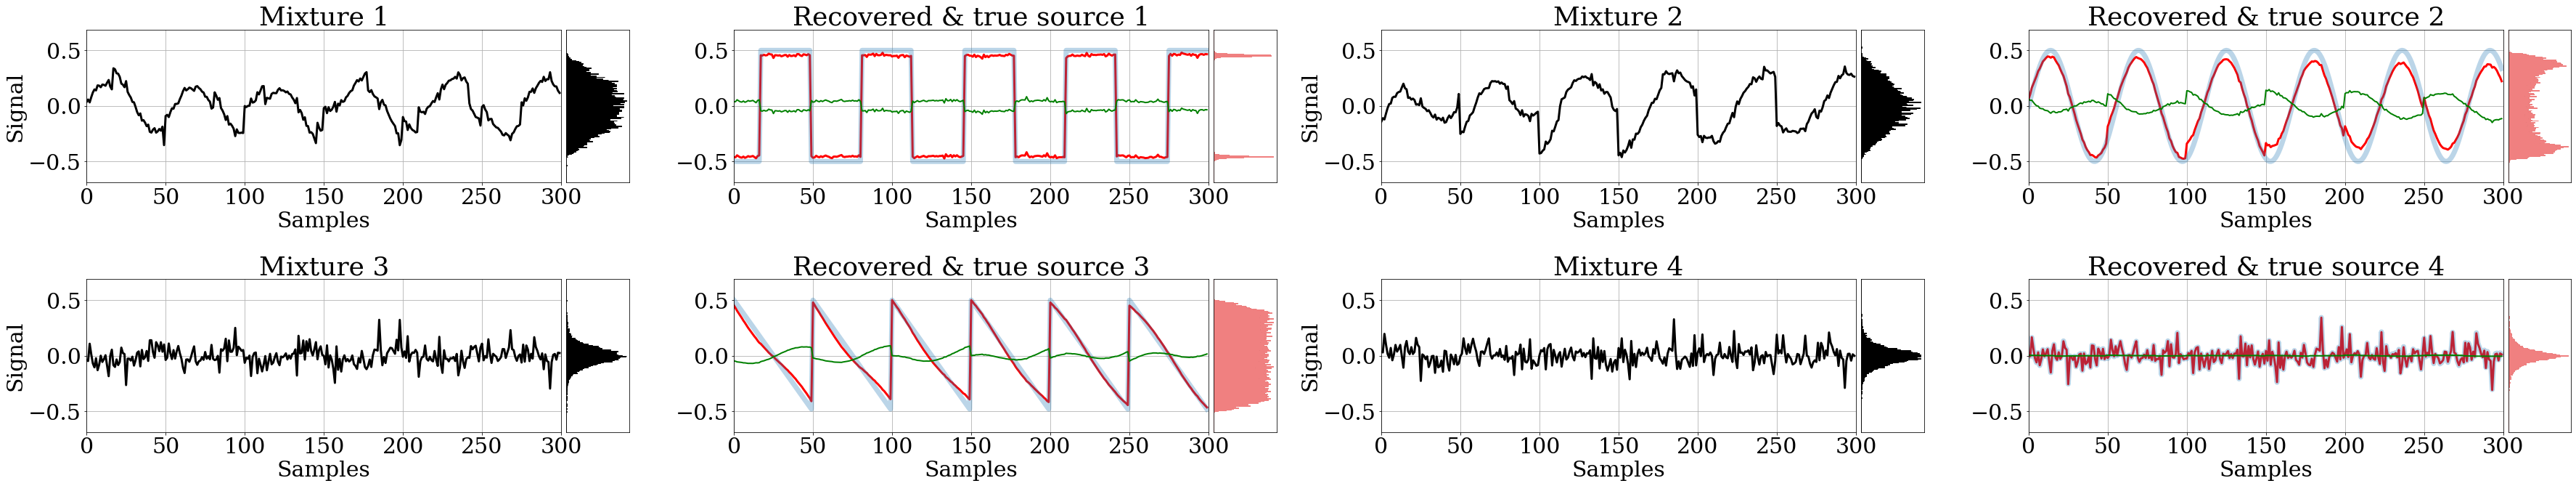

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

num_samples_plot=300
min_y_val=1.2*min(Rescaled_fobi.min(),Rescaled_Y.min())
max_y_val=1.2*max(Rescaled_fobi.max(),Rescaled_Y.max())

fig = plt.figure(figsize = (50,10))

plt.rc('font', family='serif')
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 30}

plt.rc('font', **font)


### Mixtures plot
for iter_subfigure_mixture in range(Rescaled_matrix.shape[1]):

    ax=plt.subplot(2,Rescaled_matrix.shape[1],2*iter_subfigure_mixture+1)

    plt.plot(Rescaled_matrix[:num_samples_plot,arg_sort_mixture[iter_subfigure_mixture]],"black", linewidth=3)#,label='Mixture 1')
    plt.xlabel("Samples")
    plt.ylabel("Signal")
    ax.set_xlim(0,Rescaled_Y[:num_samples_plot,0].shape[0])
    ax.set_ylim(min_y_val,max_y_val)
    #plt.legend(loc='upper right')
    ax.grid(True)
    plt.title('Mixture '+str(iter_subfigure_mixture+1))

    divider = make_axes_locatable(ax)
    axHisty = divider.append_axes("right", size=1.2, pad=0.1, sharey=ax)
    axHisty.hist(Rescaled_matrix[:,arg_sort_mixture[iter_subfigure_mixture]], bins=256, range=(min_y_val, max_y_val),fc='k', ec='k', orientation='horizontal')
    axHisty.grid(True)
    axHisty.get_xaxis().set_visible(False)
    axHisty.get_yaxis().set_visible(False)
    plt.yticks(color='w')
    plt.xticks(color='w')



### Recovered source
for iter_subfigure_source in range(Rescaled_Y.shape[1]):

    ax = plt.subplot(2,Rescaled_Y.shape[1],2*iter_subfigure_source+2)
    plt.title('Recovered & true source '+str(iter_subfigure_source+1))
    
    ax.plot(Rescaled_Y[:num_samples_plot,arg_sort_SM_ICA[iter_subfigure_source]],"red", linewidth=3,label='Ours')
    
    norm_sign_p = np.linalg.norm(Rescaled_Y[:num_samples_plot,arg_sort_SM_ICA[iter_subfigure_source]]-Rescaled_sources[:num_samples_plot,arg_sort_sources[iter_subfigure_source]])
    norm_sign_m = np.linalg.norm(Rescaled_Y[:num_samples_plot,arg_sort_SM_ICA[iter_subfigure_source]]+Rescaled_sources[:num_samples_plot,arg_sort_sources[iter_subfigure_source]])


    if norm_sign_p<norm_sign_m:
        ax.plot(Rescaled_sources[:num_samples_plot,arg_sort_sources[iter_subfigure_source]], linewidth=7, alpha=0.3,label='True')
        ax.plot(Rescaled_Y[:num_samples_plot,arg_sort_SM_ICA[iter_subfigure_source]]-Rescaled_sources[:num_samples_plot,arg_sort_sources[iter_subfigure_source]],"green", linewidth=2,label='Residual')
    else:
        ax.plot(-Rescaled_sources[:num_samples_plot,arg_sort_sources[iter_subfigure_source]], linewidth=7, alpha=0.3,label='True')
        ax.plot(Rescaled_Y[:num_samples_plot,arg_sort_SM_ICA[iter_subfigure_source]]+Rescaled_sources[:num_samples_plot,arg_sort_sources[iter_subfigure_source]],"green", linewidth=2,label='Residual')

    

    plt.xlabel("Samples")


    ax.set_xlim(0,Rescaled_Y[:num_samples_plot,0].shape[0])
    ax.set_ylim(min_y_val,max_y_val)
    ax.grid(True)

    divider = make_axes_locatable(ax)
    axHisty = divider.append_axes("right", size=1.2, pad=0.1, sharey=ax)
    axHisty.hist(Rescaled_Y[:,arg_sort_SM_ICA[iter_subfigure_source]], bins=256, range=(min_y_val, max_y_val),fc='k', ec='lightcoral', orientation='horizontal')
    axHisty.grid(True)
    axHisty.get_xaxis().set_visible(False)
    axHisty.get_yaxis().set_visible(False)

    
plt.tight_layout()

